In [186]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

## The Secretary problem

# https://www.imrankhan.dev/pages/Solving%20the%20secretary%20problem%20with%20Python.html
# https://github.com/RoyZhang7/secretary-problem/blob/master/project4.pptx.pdf
# https://changyaochen.github.io/secretary-problem/

The secretary problem consists of a scenario where an administrator wants to hire the best secretary out of 
$n$ candidates for a position, who are ranked from best to worst. These candidates are interviewed in a random order and one at a time, and after each interview they are either rejected or accepted, in which case the decision is final. 

The solution tho this problem should maximise the probability of recruiting the best candidate.

In [187]:
n = 100
candidates = np.arange(1,n+1)
np.random.shuffle(candidates)

In [188]:
candidates

array([ 70,  19,  20,  78,  86,  87,  26,  73,  22,  84, 100,   6,  28,
        40,  27,  63,  17,  91,   8,   9,  30,  90,  66,  34,  71,  25,
        37,  64,  48,   2,  55,  35,  83,  75,  38,   7,  52,  58,  62,
        98,  92,  94,  54,   3,   1,  80,  45,  18,  10,  69,  32,  49,
        41,  74,  12,   5,  44,  33,  42,  79,  51,  29,  47,  77,  88,
        61,  39,  57,  82,  21,  11,  14,  99,  95,  65,  59,  36,   4,
        85,  67,  76,  56,  50,  24,  68,  72,  81,  97,  13,  96,  15,
        43,  89,  53,  31,  60,  16,  93,  46,  23])

## The optimal stopping strategy

The solution to this problem consists of finding the rank $r^*<n$ such that the first $r^*-1$ candidates are rejected and the cadidate accepted is the next applicant who is better than all the first $r^*-1$ interviewed.

Let $i$ be the position of the best candidate. This candidate will be accepted if:

* $i \geq r^*$
* The best ranked candidate between positions $[1,i-1]$ is between positions $[1,r^*-1]$

The probability of having the best candidate in position $i$ is $\frac{1}{n}$ and the probability of having the last condition above is $\frac{r^*-1}{i-1}$.

Let our probability of success, i.e., the probability of choosing the best candidate among the $n$, be $P(r)$.

Then we have:

$$
P(r^*) = \sum_{i = r^*}^{n} \frac{1}{n} \left( \frac{r^*-1}{i-1} \right) = \frac{r^*-1}{n} \sum_{i = r^*}^{n} \frac{1}{i-1}
$$

We can notice that $P(r^*)$ is the Riemann approximation of an integral. Calling the ratio $x = \frac{r^*-1}{n}$ and taking the limit when $n \rightarrow \infty$:

$$
P(r^*) = \lim_{n\rightarrow \infty} \frac{r^*-1}{n} \sum_{i = r^*}^{n} \frac{1}{i-1} = x \int_{x}^{1}\frac{1}{t} dt = -x lnx
$$

If we maximize the above expression, we get the optimal result:

$$
x = \frac{1}{e} \Rightarrow r^* - 1 = \frac{n}{e}
$$

Finally, the optimal solution is to reject the first $\frac{n}{e}$ candidates and chose the first candidate who is better than the $\frac{n}{e}$ candidates rejected. In the case where there is no better candidate interviewed, choose the last one.

In [189]:
stop = int(round(n/np.e))
best_from_rejected = np.min(candidates[:stop])
candidates_left = candidates[stop:]

In [190]:
chosen_candidate = 0
for c in candidates_left:
    if c < best_from_rejected:
        chosen_candidate = c
        break

chosen_candidate

1

In [191]:
def choose_candidate(n):
    candidates = np.arange(1,n+1)
    np.random.shuffle(candidates)

    stop = int(round(n/np.e))
    best_rejected_candidate = np.min(candidates[:stop])
    candidates_left = candidates[stop:]
    
    for c in candidates_left:
        if c < best_rejected_candidate:
            return c
    return candidates_left[-1]

## Simulating the optimal strategy

Now let's simulate 10000 times the problem, with $n=100$ candidates

In [192]:
N = 10_000
n = 100
results = []

for sim in range(N):
    results.append(choose_candidate(n))

results = pd.Series(results)

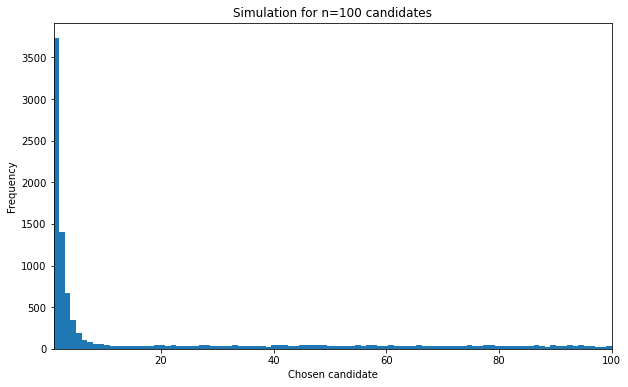

In [193]:
plt.figure(figsize=(10,6))
plt.hist(results, bins=n)
plt.xlim(1,n)
plt.title(f'Simulation for n={n} candidates')
plt.xlabel('Chosen candidate')
plt.ylabel('Frequency')
plt.show()

Most of the times the best candidate (number 1) is chosen and, if not him, there is a high chance of choosing one of the best $10%$ candidates. This can be seen by plotting the cumulative density function of the distribution:

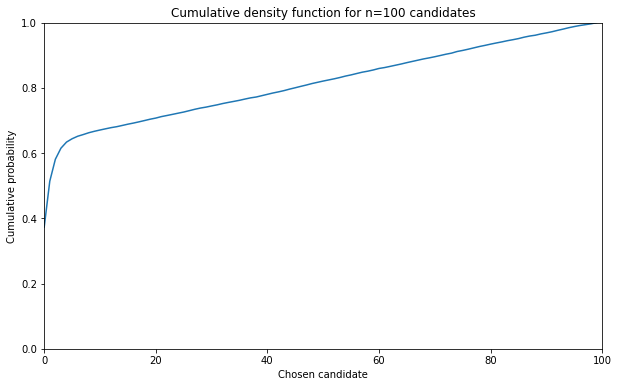

In [194]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(np.histogram(results, bins=n)[0])/N)
plt.ylim(0,1)
plt.xlim(0,n)
plt.title(f'Cumulative density function for n={n} candidates')
plt.xlabel('Chosen candidate')
plt.ylabel('Cumulative probability')
plt.show()

We see that $37\%$ of the simulations were a success, and the probability of choosing one of the best 5 candidates is $63\%$:

In [195]:
results = pd.Series(results)
results.value_counts(1)

1     0.3731
2     0.1408
3     0.0672
4     0.0340
5     0.0187
       ...  
62    0.0028
98    0.0026
39    0.0026
99    0.0026
89    0.0025
Name: proportion, Length: 100, dtype: float64

In [196]:
results.value_counts(1).sort_index().head(5).sum()

0.6338000000000001

## Simulating other strategies

We can also show that the strategy previously described is optimal, i.e., is the one that leads to a higher probability of choosing the best candidate. To do it, we'll change the stopping rule and reject other values than $\frac{1}{e}$% of the candidates. The fraction of candidates rejected will vary from $0.05$ to $1$ with steps of $0.01$.

In [197]:
def choose_candidate_not_opt(n, rejection_rate):
    candidates = np.arange(1,n+1)
    np.random.shuffle(candidates)

    stop = int(round(rejection_rate*n)) 
    best_rejected_candidate = np.min(candidates[:stop])
    candidates_left = candidates[stop:]

    for c in candidates_left:
        if c < best_rejected_candidate:
            return c
    return candidates[-1]

In [198]:
N = 10_000
n = 100
prob_choose_best = []
rates = np.arange(0.05,1,0.01)

for r in rates:
    results = []
    for sim in range(N):
        results.append(choose_candidate_not_opt(n,r))
    prob_choose_best.append(results.count(1)/N)

prob_choose_best = pd.Series(prob_choose_best)


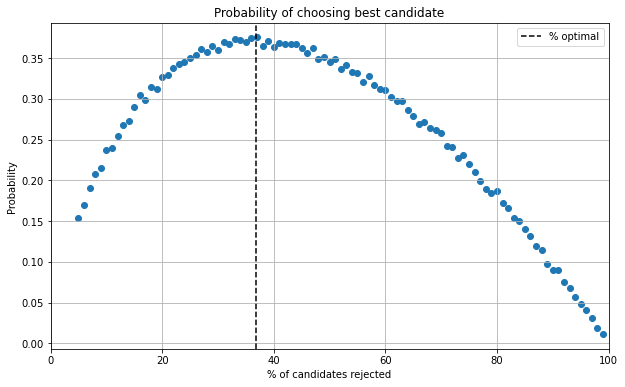

In [199]:
plt.figure(figsize=(10,6))
plt.scatter(rates*100,prob_choose_best)
plt.xlim(0,100)
plt.title("Probability of choosing best candidate")
plt.xlabel("% of candidates rejected")
plt.ylabel("Probability")
plt.grid()
plt.axvline(1/np.e*100, ls='--', c='black', label='% optimal')
plt.legend()
plt.show()

We can see that the rejection percentage that maximizes the probability of choosing the best candidate is $37\%$, which was expected from the optimal strategy derived above

In [200]:
1/np.e

0.36787944117144233

In [201]:
prob_choose_best.index = rates
prob_choose_best.sort_values(ascending=False)

0.37    0.3752
0.36    0.3748
0.33    0.3734
0.34    0.3716
0.39    0.3708
         ...  
0.95    0.0479
0.96    0.0403
0.97    0.0304
0.98    0.0186
0.99    0.0114
Length: 95, dtype: float64